# Importing Modules

In [1]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')

# Loading Data and split it into train and test

In [3]:
BATCH_SIZE = 8 # Set the batch size to 16
ROOT_DIR = './data/Glioma' # Set the root directory to the Glioma dataset

In [4]:
# Define the Dataset class
class BrainTumorDataset(Dataset):
    def __init__(self,images, root_dir, transform=None):
        self.images = images 
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_name = self.images[idx]
        img_path = os.path.join(self.root_dir, image_name)
        mask_name = image_name.replace('.png', '_mask.png')
        mask_path = os.path.join(self.root_dir, mask_name)
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask
    

In [5]:
# Load the images and masks

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Get the list of images
all_images = [file for file in os.listdir(ROOT_DIR) if file.endswith('.png') and '_mask' not in file]

# Split the images into training and testing sets
train_files, test_files = train_test_split(all_images, test_size=0.2, random_state=42)

# Create the training and testing datasets
train_dataset = BrainTumorDataset(train_files, ROOT_DIR, transform=transform)
test_dataset = BrainTumorDataset(test_files, ROOT_DIR, transform=transform)

# Create the training and testing dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training Batch - Image Shape: torch.Size([8, 3, 512, 512]), Mask Shape: torch.Size([8, 1, 512, 512])


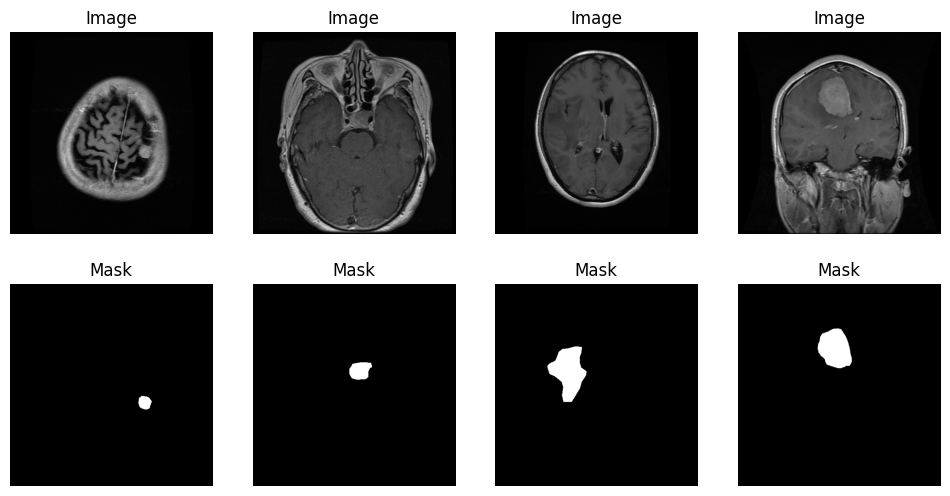

Testing Batch - Image Shape: torch.Size([8, 3, 512, 512]), Mask Shape: torch.Size([8, 1, 512, 512])


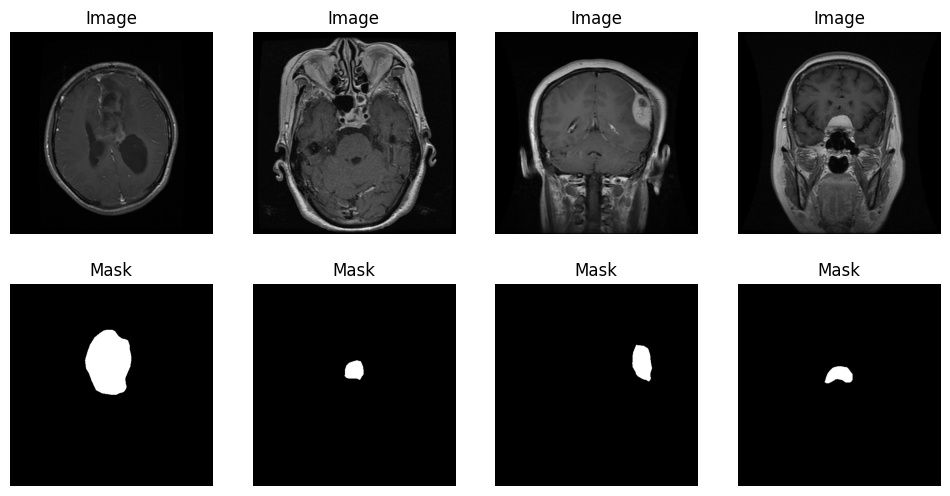

In [6]:
# Display a few images and masks
def display_image_mask(images, masks):
    fig,axes = plt.subplots(2,4,figsize=(12,6))
    for i in range(4):
        axes[0,i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].set_title('Image')
        axes[0,i].axis('off')
        axes[1,i].imshow(masks[i][0], cmap='gray')
        axes[1, i].set_title('Mask')
        axes[1,i].axis('off')
    plt.show()

# Get a batch of training data
images, masks = next(iter(train_loader))
print(f"Training Batch - Image Shape: {images.shape}, Mask Shape: {masks.shape}")
display_image_mask(images, masks)

# Get a batch of testing data
images, masks = next(iter(test_loader))
print(f"Testing Batch - Image Shape: {images.shape}, Mask Shape: {masks.shape}")
display_image_mask(images, masks)

In [7]:
# Print the number of batches in the train and test loaders
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in train loader: 143
Number of batches in test loader: 36


# Model Creation

### Parts of U-Net

In [20]:
# Convolution Block
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels,padding = 0):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

# Downsample Block 
class DownsampleBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x

# Upsample Block
class UpsampleBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels*2, out_channels)
    
    def forward(self, x, down_tensor):
        x = self.upsample(x)
        x = torch.cat([x, down_tensor], dim=1)
        x = self.conv(x)
        return x


### U-Net Model

In [21]:
# Defining UNet Model
class UNet(torch.nn.Module):
    # Define the init method
    def __init__(self, in_channels, out_channels):
        # Call the super class constructor
        super(UNet,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Define the Layers
        # Downsample layers
        self.down1 = ConvBlock(in_channels, 64)
        self.down2 = DownsampleBlock(64, 128)
        self.down3 = DownsampleBlock(128, 256)
        self.down4 = DownsampleBlock(256, 512)
        # Bottleneck layers
        self.b = ConvBlock(1024, 1024)
        # Upsample layers
        self.up1 = UpsampleBlock(1024, 512)
        self.up2 = UpsampleBlock(512, 256)
        self.up3 = UpsampleBlock(256, 128)
        self.up4 = UpsampleBlock(128, 64)
        self.outc = ConvBlock(64, out_channels)

    # Define the forward method
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.b(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
    
    # Define Checkpointing
    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
        

In [17]:
# Function to display images and masks
def compare_segmented(images, preds, masks):
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i in range(4):
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].set_title('Image')
        axes[0, i].axis('off')
        axes[1, i].imshow(preds[i][0], cmap='gray')
        axes[1, i].set_title('Mask - Predicted')
        axes[1, i].axis('off')
        axes[2, i].imshow(masks[i][0], cmap='gray')
        axes[2, i].set_title('Mask - Ground Truth')
        axes[2, i].axis('off')
    plt.show()


In [25]:
model = UNet(in_channels=3,out_channels=1).to(device)  # Assuming binary segmentation

for images, masks in train_loader:
    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images).detach().numpy()
    print("Output shape: ",outputs.shape)
    compare_segmented(images, outputs, masks)
    break

KeyboardInterrupt: 